# Bounty: Uniswap shiny NFTs

Is there a way to figure out who got Shiny NFTs? What is the concentration of shiny NFTs in the hands of the 20 largest Liquidity Providers by TVL on Uniswap?

**Initialising notebook**

In [35]:
from matplotlib import pyplot as plt
import rare
import pandas as pd
import requests
import math
from web3 import Web3
from IPython.display import Image

**Importing position data from Flipside**

In [36]:
url = 'https://api.flipsidecrypto.com/api/v2/queries/4c9dcef8-7ca3-4192-8288-6e4354a96300/data/latest'
response = requests.get(url)
df = pd.DataFrame(response.json())

url = 'https://api.flipsidecrypto.com/api/v2/queries/97acbb69-8689-4507-8306-f6a36375cd30/data/latest'
response = requests.get(url)
df2 = pd.DataFrame(response.json())

df = pd.concat([df, df2]).drop_duplicates()

print(df.head(2))

                           LIQUIDITY_PROVIDER  NF_TOKEN_ID  \
0  0x11e4857bb9993a50c685a79afad4e6f65d518dda            1   
1  0x4bd047ca72fa05f0b89ad08fe5ba5ccdc07dffbf            2   

                                 POOL_ADDRESS  
0  0x1d42064fc4beb5f8aaf85f4617ae8b3b5b8bd801  
1  0x6c6bc977e13df9b0de53b251522280bb72383700  


**Defining the reverse-engineered rare NFTs function from Uniswap source code**

From https://github.com/Uniswap/uniswap-v3-periphery/blob/b771ff9a20a0fd7c3233df0eb70d4fa084766cde/contracts/libraries/NFTSVG.sol

The function determines whether a particular NFT is rare based on the formula in the image below, we can reverse-engineer this to find which NFTs are rare.

Interestingly, we can see the rarity of shiny NFTs grows as more are minted, with a 'difficulty bomb' every 2^(2^i) NFTs minted (where i is a positive integer)

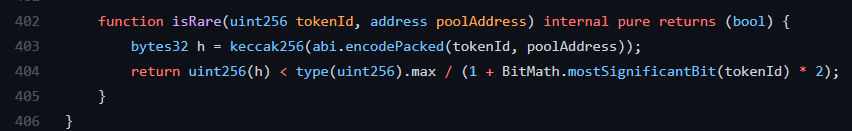

In [7]:
display(Image(filename='israre.png'))

Using the Python web3 library we can emulate the function as per below

In [37]:
def rareTest(x, address):

    y = math.log2(x)

    temp = 0
    for pow in range(1,256):
        if y >= 2**pow:
            temp += pow

    x = Web3.toInt(Web3.solidityKeccak(['uint256', 'address'], [x, Web3.toChecksumAddress(address)]))

    return x <= Web3.toInt(2**256-1)/(1 + temp * 2)

**We can now iterate over all the positions to determine which belong to the elusive shiny group**

In [38]:
df['rare'] = df.apply(lambda x : rareTest(x['NF_TOKEN_ID'], x['POOL_ADDRESS']), axis = 1)

print(df[['NF_TOKEN_ID', 'rare']].head(5))

   NF_TOKEN_ID   rare
0            1   True
1            2   True
2            3   True
3            4  False
4            5   True


**The first 5 NFTs minted are shiny, with the exception of number 4!** 

To validate this we can view these NFTs in the Uniswap front-end and lo-and-behold they all have the symbol of rarity *

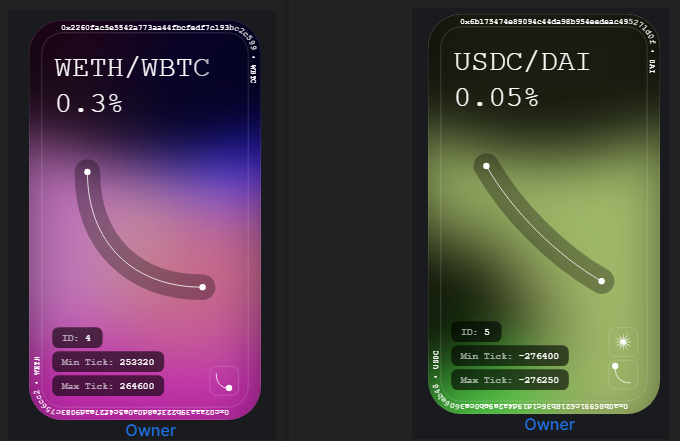

In [17]:
display(Image(filename='validation.png'))

**Now that we've identified them, how many are there?**


There are 7670 Shiny NFTs
Out of a total of 118045
Representing a current chance of a shiny NFT at 6.5%



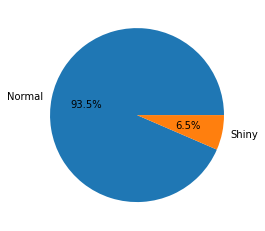

In [39]:
string = f'''
There are {df['rare'].sum()} Shiny NFTs
Out of a total of {df['rare'].count()}
Representing a current chance of a shiny NFT at {round(df['rare'].sum()/df['rare'].count()*100,2)}%
'''
print(string)

fig, ax = plt.subplots()
ax.pie([df['NF_TOKEN_ID'].count()-df['rare'].sum(),df['rare'].sum()], labels = ['Normal', 'Shiny'],autopct='%1.1f%%')
plt.show()

**Now we can identify how many are owned by the top 20 LPs**

I have identified the top 20 LPs by TVL in the top 10 pools using the query below.

In [40]:
url = 'https://api.flipsidecrypto.com/api/v2/queries/5bd38439-1938-4a0a-a781-5e51f8da1181/data/latest'
response = requests.get(url)
whale_df = pd.DataFrame(response.json())

In [44]:
count_df = df[df['LIQUIDITY_PROVIDER'].isin(whale_df['LIQUIDITY_PROVIDER'])].groupby('LIQUIDITY_PROVIDER').agg({'rare':'sum','NF_TOKEN_ID':'count'})
print(count_df)

                                            rare  NF_TOKEN_ID
LIQUIDITY_PROVIDER                                           
0x119454fcd0c84b3e44cec59a718848c70987935f     0            3
0x1578ed833d986c1188d1a998aa5fecd418bef5da     1            2
0x2bb718a3986c36c6e02d8d15cda4370820d08169     0            7
0x342bf4e93930b576b24df05b44dd845305d87e0d     2            6
0x47441bd9fb3441370cb5b6c4684a0104353aec66     0           10
0x6555e1cc97d3cba6eaddebbcd7ca51d75771e0b8     3           26
0x66721b617dfdbca40dbc1a92fb0907abb764235a     0            1
0x70fcbd3f1abbc076259b2f200171b067d7ca75b0     0            7
0x741aa7cfb2c7bf2a1e7d4da2e3df6a56ca4131f3     4           83
0x888e1b67bfb11d6a68c43a6af939b89d8defb2bb     0            2
0x8dbe8722557b97a956bac439858d107108cf7b8a     3           18
0x94b1fc7695b9d596e5b65b2b4f3d05d0069bc012     1           19
0x9b0297ce4ebcf554a2000ebd60987298a9bc314b     1           29
0xa0f75491720835b36edc92d06ddc468d201e9b73     0            7
0xa507b3

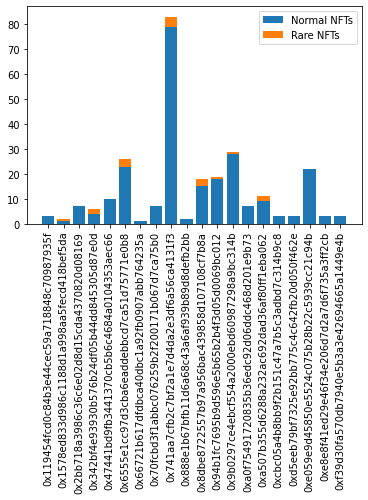

In [60]:
fig2, ax2 = plt.subplots()

ax2.bar(x = count_df.index, height = count_df['NF_TOKEN_ID'] - count_df['rare'], label = 'Normal NFTs')
ax2.bar(count_df.index, count_df['rare'], bottom = count_df['NF_TOKEN_ID'] - count_df['rare'], label = 'Rare NFTs')
plt.xticks(rotation = 90)
plt.legend()
plt.show()

In [65]:
string = f'''
In total, the top 20 LPs own {count_df['rare'].sum()} shiny NFTs.
This represents {round(count_df['rare'].sum()/df['rare'].sum()*100,2)}% of all shiny NFTs.
While they own a total of {round(count_df['NF_TOKEN_ID'].sum()/df['NF_TOKEN_ID'].count()*100,2)}% of all NFTs minted.
'''
print(string)


In total, the top 20 LPs own 17 shiny NFTs.
This represents 0.22% of all shiny NFTs.
While they own a total of 0.22% of all NFTs minted



### In a surprising conclusion, shiny NFTs are equally concentrated amongst the top LP providers as they are amongst us regular folk

In [73]:
x = df[['rare', 'LIQUIDITY_PROVIDER']].groupby(df['LIQUIDITY_PROVIDER']).sum()
print(x.nlargest(1,'rare'))

                                            rare
LIQUIDITY_PROVIDER                              
0x335c0552eb130f3dfbe6efcb4d2895aed1e9938b    50


### The luckiest LPer of all, *0x335c0552eb130f3dfbe6efcb4d2895aed1e9938b* owns 50 shiny NFTs.